In [12]:
import torch
from PIL import Image
import requests


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
# from google.colab.patches import cv2_imshow
import re
from bs4 import BeautifulSoup #for reading xml file
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud
from tqdm import tqdm
from PIL import Image    
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib #for saving model files as pkl files
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math

In [3]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [4]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["caption"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [60]:
from datasets import load_dataset
from datasets import load_from_disk
val_data = load_from_disk('all_data/datasets/val')
test_data = load_from_disk('all_data/datasets/test')

In [7]:
%pwd

'/Users/simranmasand/Downloads'

In [10]:
from torch.utils.data import DataLoader

val_dataset = ImageCaptioningDataset(val_data["train"], processor)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1)

In [126]:
model_path='all_data/checkpoint/roco_prefix_latest.pt'

In [87]:
CPU = torch.device('mps')
model.load_state_dict(torch.load(model_path, map_location=CPU)) 


<All keys matched successfully>

In [36]:
model.eval()


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [61]:
val_data

DatasetDict({
    train: Dataset({
        features: ['image', 'Unnamed: 0', 'id', 'caption'],
        num_rows: 8175
    })
})

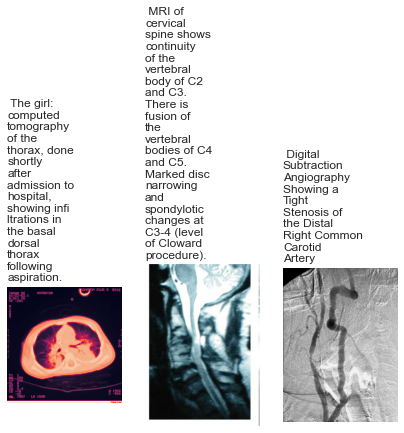

In [75]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(7, 7))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption,loc='left')
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(val_data["train"][i]["image"]) for i in range(3)]
sample_captions = [val_data["train"][i]["caption"] for i in range(3)]
plot_images(sample_images_to_visualize, sample_captions)

In [22]:
# def transforms(example_batch):
#     images = [x for x in example_batch["image"]]
#     captions = [x for x in example_batch["caption"]]
#     inputs = processor(images=images, text=captions, padding="max_length")
#     inputs.update({"labels": inputs["input_ids"]})
#     return inputs


# val_data["train"].set_transform(transforms)

In [69]:
val_data["train"][6]["caption"].replace("\n","").strip()

'Arterial phase of the computed tomography scan of the abdomen shows a hypervascularized area (arrows) in the pancreatic body.'

In [26]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [136]:
val_data["train"][7000]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=551x551>,
 'Unnamed: 0': 4757,
 'id': 'ROCO_48356',
 'caption': ' Cardiac catheterization which demonstrated blockage of the left anterior descending artery.\n'}

In [137]:
image = val_data["train"][7000]["image"]
inputs = processor(images=image, return_tensors="pt")#.to(device) .astype(np.uint8)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

the patient's chest radiograph shows a large right pleural effusion with a large pleural effusion.


In [64]:
import nltk.translate.bleu_score as bleu


In [70]:
bleu.sentence_bleu(val_data["train"][6]["caption"].replace("\n","").strip().split(),generated_caption.split(),weights=(1, 0, 0, 0))

0.0583448879361965

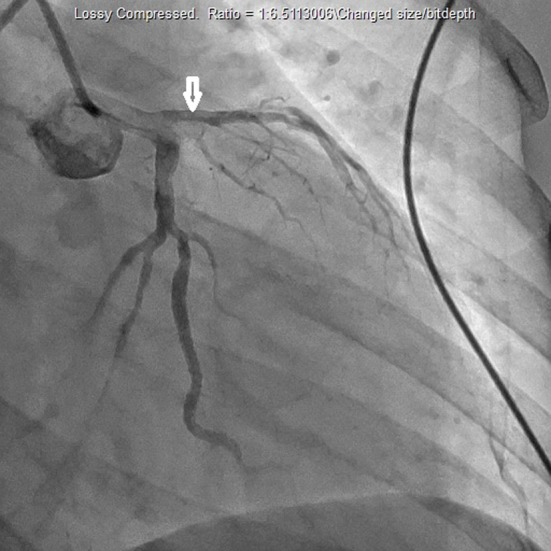

In [138]:
val_data["train"][7000]["image"]

In [100]:
val_data["train"][55]["caption"]

' Muscle rupture with intact external abdominal muscle one week after admission.\n'

In [77]:
OG="the tracheostomy tube is in stable position. right subclavian catheter tip is in the lower svc. the left upper etremity picc tip is in the mid svc. surgical overlie the soft tissues of the neck. the lungs are clear. heart size is normal. no pneumothora."
PG="the lungs are clear. there is no pleural effusion or pneumothora. the heart and mediastinum are normal. the skeletal structures are normal."

In [79]:
Adj = " the lungs are clear. heart size is normal. no pneumothora."

In [80]:
bleu.sentence_bleu(OG.split(),Adj.split(),weights=(1, 0, 0, 0))

0

## Testing loop; add BLEU and cider metric; accuracy and plots

https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_captioning_blip.ipynb#scrollTo=AFGnjCgDoLIJ

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")

In [ ]:
b1 = 0
b2 = 0
b3 = 0
b4 = 0


for i in range(X_test.shape[0]):
  im_o = np.vstack(X_test[:,4][i]).astype(np.float)
  pred = beam(im_o)
  org= X_test[:,5][i]

  

  
  b1 =  b1 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(1, 0, 0, 0))
  b2 =  b2 + bleu.sentence_bleu([org.split()], pred.split(),weights=(0.5, 0.5, 0, 0))
  b3 =  b3 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(0.33, 0.33, 0.33, 0))
  b4 =  b4 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(0.25, 0.25, 0.25, 0.25))



print("Bleu1 score is : ",b1/X_test.shape[0])
print("Bleu2 score is : ",b2/X_test.shape[0])
print("Bleu3 score is : ",b3/X_test.shape[0])
print("Bleu4 score is : ",b4/X_test.shape[0])